<a href="https://colab.research.google.com/github/timisoetan/545/blob/main/Copy_of_Project_CIS_545.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIS 545 Project on COVID-19 Data
Ibrahim Fagbamila

Timi Soetan

Kamran Elahi

# Introduction & Background

---

Given the global COVID-19 pandemic, we wanted to explore the relationship between the movement of people in the U.S. and the spread of COVID-19. We gathered different kinds of data from different sources.

We use publicly availible data from the U.S. Department of Transportation to see how many people leave their home each day and how far they go. (https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv/data)


We get publicly availible data from USAFacts.org on the number of deaths and cases over an extensive period of time covering much of the lockdown and COVID-19 pandemic. (https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)

 We then combine these datasets below into a time series format in order to properly process it. We conduct data cleaning and wrangling, droping Nulls where appropriate and removing U.S. counties where the data has too many gaps to be useful in our analysis. Our final product is **merged_df**.

In [ ]:
# Sklearn and Pandas Setup
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [ ]:
airline_delay_cause_df = pd.read_csv('./Airline_Delay_Cause.csv')
covid_confirmed_df = pd.read_csv('./covid_confirmed_usafacts.csv')
covid_deaths_df = pd.read_csv('./covid_deaths_usafacts.csv')
trips_by_distance_df = pd.read_csv('./Trips_by_Distance.csv')

In [ ]:
# Remove counties with 'Statewide Unallocated'
covid_confirmed_df =  covid_confirmed_df[covid_confirmed_df['County Name'] != 'Statewide Unallocated']
covid_deaths_df =  covid_deaths_df[covid_deaths_df['County Name'] != 'Statewide Unallocated']

In [ ]:
trips_by_distance_df = trips_by_distance_df[trips_by_distance_df['Level'] == 'County']
trips_by_distance_df['Date'] = pd.to_datetime(trips_by_distance_df['Date'])
trips_by_distance_df = trips_by_distance_df[trips_by_distance_df['Date'] >= pd.to_datetime('01/22/2020') ]
# trips_by_distance_df = trips_by_distance_df[trips_by_distance_df['Date'] <= pd.to_datetime('03/20/2022')]
# START: 2020-01-22
# END: 2022-03-20

In [ ]:
# covid_confirmed_df
# covid_deaths_df
# START: 2020-01-22
# END: 2022-03-20

########################################################
##################  THINGS TO DO:  #####################
########################################################
# 1. map covid_dfs from COUNTY to CITY [ ]
# 2. Remove counties with 'Statewide Unallocated' [ X ]
# 2. Aggregate covid_dfs from indiv dates to months. [ X ]
########################################################

date_cols = list(covid_confirmed_df.columns)
date_cols.remove('countyFIPS')
date_cols.remove('County Name')
date_cols.remove('State')
date_cols.remove('StateFIPS')
date_cols = pd.to_datetime(date_cols)

month_date_tuples = list(itertools.chain.from_iterable([[(month, year) for month in range(1,13)] for year in range(2020, 2023)]))

for m,y in month_date_tuples:
  date_range = [str(x)[:10] for x in date_cols if x.month == m and x.year == y]
  # column of sum of all cases for month (m) and year (y) for every county(index)
  agg_monthly_cases_col = covid_confirmed_df.apply(lambda x : x[date_range], axis=1).sum(axis=1)
  agg_monthly_deaths_col = covid_deaths_df.apply(lambda x : x[date_range], axis=1).sum(axis=1)

  covid_confirmed_df = covid_confirmed_df.drop(date_range, axis=1) # drop date_range columns
  covid_deaths_df = covid_deaths_df.drop(date_range, axis=1) # drop date_range columns

  covid_deaths_df['{}-{}'.format(m,y)] = agg_monthly_deaths_col # add single agg_monthly_deaths_col column
  covid_confirmed_df['{}-{}'.format(m,y)] = agg_monthly_cases_col # add single agg_monthly_cases_col column

In [ ]:
# covid_confirmed_df[covid_confirmed_df['County Name'] == 'Autauga County'] #repalce county name with city eventually after mapping stuff
# airline_delay_cause_df
mon_year_cols = [x for x in covid_confirmed_df.columns if '-' in x]
confirmed_cases_2d_array = list(covid_confirmed_df.apply(lambda x : list(x[mon_year_cols]), axis=1))
confirmed_deaths_2d_array = list(covid_deaths_df.apply(lambda x : list(x[mon_year_cols]), axis=1))

In [ ]:
temp = list(covid_confirmed_df[['countyFIPS', 'StateFIPS', 'County Name', 'State', ]].apply(lambda x : list(x), axis=1))
data = []

In [ ]:
for i in range(len(confirmed_cases_2d_array)): #3142
  for j in range(36): #36
    row = temp[i] + [mon_year_cols[j]] + [confirmed_cases_2d_array[i][j]] + [confirmed_deaths_2d_array[i][j]]
    # print(row)
    data.append(row)

In [ ]:
# make df from data
# NOTE: I excluded columns 'countyFIPS' and 'StateFIPS'
df = pd.DataFrame(data, columns = ['countyFIPS', 'StateFIPS', 'County Name', 'State', 'month_year', 'cases', 'deaths',])

# split 'month_year' into 2 columns
df['month'] = df['month_year'].apply(lambda x : int(x.split('-')[0]))
df['year'] = df['month_year'].apply(lambda x : int(x.split('-')[1]))
df['County Name'] = df['County Name'].str.strip()
df = df[['countyFIPS', 'County Name', 'State', 'cases', 'deaths', 'month', 'year']]

# remove data after March 2022
df = df.loc[~((df['month'] >= 4) & (df['year'] == 2022))]

In [ ]:
df

,countyFIPS,County Name,State,cases,deaths,month,year
0,1001,Autauga County,AL,0.0,0.0,1,2020
1,1001,Autauga County,AL,0.0,0.0,2,2020
2,1001,Autauga County,AL,43.0,0.0,3,2020
3,1001,Autauga County,AL,729.0,35.0,4,2020
4,1001,Autauga County,AL,3663.0,95.0,5,2020
...,...,...,...,...,...,...,...
113098,56045,Weston County,WY,35167.0,337.0,11,2021
113099,56045,Weston County,WY,38047.0,434.0,12,2021
113100,56045,Weston County,WY,40962.0,490.0,1,2022
113101,56045,Weston County,WY,42536.0,483.0,2,2022


Consider **trips_by_distance_df**. Drop all rows that have counties that are not also in **df**.

In [ ]:
# https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv/data

# trips_by_distance_df.sort_values(by='County Name')[trips_by_distance_df['County Name'] == 'Abbeville County']
# len(list(trips_by_distance_df['County Name'])) # 168796
# len(list(df['County Name'])) # 84834

df_names_list = list(df['County Name'])
trips_names_list = list(trips_by_distance_df['County Name'])

In [ ]:
common_county_names = list(set(trips_names_list) - set(df_names_list))


# dates_df = list(set(df.apply(lambda x : (x.year, x.month), axis=1)))
# dates_trips = [(x.year, x.month, x.day) for x in trips_by_distance_df['Date']]


# dates_df.sort()
# print(dates_df)

# dates_trips.sort()
# print(dates_trips)

trips_by_distance_df = trips_by_distance_df[trips_by_distance_df['Level'] == 'County']

# final columns estimate:
# year, month, county, state, cases, deaths, average stayed home (per month+year), average traveled 10mi from home (per month+year), average 50mi,,,

#maybe weekday or weekend + weather?
# trips_by_distance_df = trips_by_distance_df.drop(['level_0', 'index'],axis=1)
trips_by_distance_df['Date'] = pd.to_datetime(trips_by_distance_df['Date'])
trips_by_distance_df['Year'] = trips_by_distance_df['Date'].apply(lambda x: x.year)
trips_by_distance_df['County Name'] = trips_by_distance_df['County Name'].str.strip()

In [ ]:
trips_by_distance_df

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month,Year
21061,County,2021-06-06,56.0,WY,56045.0,Weston County,1268.0,5659.0,22471.0,4160.0,...,5723.0,2202.0,3930.0,1160.0,166.0,23.0,56-56045-20210606,23,6,2021
22762,County,2021-06-06,5.0,AR,5011.0,Bradley County,1780.0,8983.0,25022.0,3411.0,...,3343.0,1793.0,1383.0,690.0,35.0,0.0,05-05011-20210606,23,6,2021
22763,County,2021-06-06,5.0,AR,5013.0,Calhoun County,571.0,4618.0,17543.0,2166.0,...,4277.0,1141.0,530.0,425.0,41.0,0.0,05-05013-20210606,23,6,2021
22764,County,2021-06-06,5.0,AR,5015.0,Carroll County,4386.0,23994.0,77047.0,14712.0,...,14712.0,4272.0,1227.0,1323.0,132.0,36.0,05-05015-20210606,23,6,2021
22765,County,2021-06-06,5.0,AR,5017.0,Chicot County,1356.0,8762.0,31550.0,9483.0,...,3857.0,1380.0,580.0,957.0,61.0,4.0,05-05017-20210606,23,6,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615239,County,2022-02-05,1.0,AL,1067.0,Henry County,1946.0,15259.0,69069.0,11791.0,...,14642.0,6865.0,1959.0,975.0,122.0,20.0,01-01067-20220205,5,2,2022
3615240,County,2022-02-05,1.0,AL,1069.0,Houston County,18024.0,87858.0,369592.0,93860.0,...,50254.0,15617.0,8234.0,3115.0,755.0,138.0,01-01069-20220205,5,2,2022
3615241,County,2022-02-05,1.0,AL,1071.0,Jackson County,7857.0,43769.0,186441.0,33567.0,...,34943.0,16311.0,3820.0,1378.0,214.0,16.0,01-01071-20220205,5,2,2022
3615243,County,2022-02-05,1.0,AL,1073.0,Jefferson County,140986.0,517587.0,1991573.0,519985.0,...,332839.0,79186.0,30824.0,16897.0,3635.0,669.0,01-01073-20220205,5,2,2022


In [ ]:
## TESTING

desired_columns_from_trips = ['Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500']

final_df = trips_by_distance_df.groupby(['County Name', 'Month', 'Year'])[desired_columns_from_trips].mean().reset_index()

df = df.rename(columns={'year': 'Year', 'month': 'Month'})
merged_df = final_df.merge(df, how='outer', on=['County Name', 'Month', 'Year']).dropna()
merged_df['Total Population'] = merged_df['Population Staying at Home'] + merged_df['Population Not Staying at Home']

In [ ]:
merged_df

,County Name,Month,Year,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,...,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,countyFIPS,State,cases,deaths,Total Population
0,Abbeville County,1,2020,4232.300000,20294.700000,83310.300000,15548.500000,18629.900000,11017.200000,11989.400000,...,6316.300000,1689.700000,350.900000,108.400000,35.800000,45001,SC,0.0,0.0,24527.0
1,Abbeville County,1,2021,4039.096774,20487.903226,85772.451613,15668.548387,17198.580645,10699.290323,14841.354839,...,6070.451613,1507.903226,324.645161,40.580645,16.612903,45001,SC,46891.0,834.0,24527.0
2,Abbeville County,1,2022,3724.709677,20802.290323,96813.774194,17439.387097,23709.032258,11725.483871,17461.161290,...,7026.064516,1246.193548,367.806452,41.741935,18.516129,45001,SC,160983.0,1750.0,24527.0
3,Abbeville County,2,2020,4006.965517,20520.034483,80651.827586,14408.103448,17615.241379,10403.620690,12275.034483,...,5821.896552,1685.034483,491.827586,71.206897,78.068966,45001,SC,0.0,0.0,24527.0
4,Abbeville County,2,2021,3534.428571,20992.571429,100145.285714,20369.750000,19399.357143,11808.428571,16285.000000,...,7368.107143,1929.857143,303.214286,41.571429,17.964286,45001,SC,58234.0,918.0,24527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81687,Ziebach County,10,2021,534.870968,2221.129032,12661.580645,1575.806452,1463.709677,94.516129,274.580645,...,5237.709677,800.709677,94.548387,0.000000,0.000000,46137,SD,12085.0,284.0,2756.0
81688,Ziebach County,11,2020,631.827586,2124.172414,21155.724138,4412.965517,3985.275862,402.758621,468.482759,...,5360.310345,1235.586207,179.827586,0.000000,0.000000,46137,SD,4404.0,114.0,2756.0
81689,Ziebach County,11,2021,559.533333,2196.466667,10873.866667,1298.833333,2013.066667,193.600000,239.466667,...,3550.033333,636.200000,96.533333,0.000000,0.000000,46137,SD,13498.0,300.0,2756.0
81690,Ziebach County,12,2020,686.516129,2069.483871,15326.161290,3017.032258,2612.096774,235.064516,318.000000,...,4157.096774,958.161290,208.516129,0.000000,0.000000,46137,SD,8229.0,219.0,2756.0


# Exploritory Data Analysis

---

*   **Coerrelational Heatmap:**
We  wanted to see how and/or if the inputs were correlated. Clearely they are however this should not necessarily be a concern in our case.

*   **Cases and Deaths Over Time by County Plot:** The GIFs below show the change in cases and deaths respectively over the span of time we examined. It is condenced to month-year intervals for clarity.

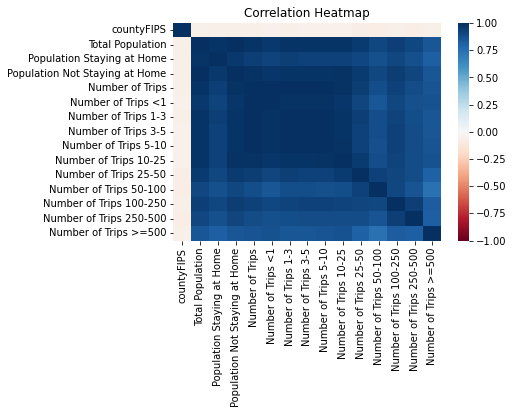

<Figure size 576x576 with 0 Axes>

In [ ]:
# merged_df
# corr_matrix = merged_df.corr()

corr_matrix = merged_df[['countyFIPS', 'Total Population', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500']].corr()

# # TO-DO: Plot correlation heatmap (4 points)
dataplot = sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1).set(title='Correlation Heatmap')
plt.figure(figsize = (8,8))
plt.show()

In [ ]:
# Geographical Map

!pip install --upgrade plotly
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade plotly-geo
!pip install colour
!pip install -U kaleido

In [ ]:
import plotly as plty
import plotly.figure_factory as ff
from colour import Color
import warnings

In [ ]:
# Geographical Maps #
#################################
###### Deaths over Time GIF ######
#################################
merged_df['countyFIPS'] = merged_df['countyFIPS'].apply(lambda x : str(int(x)) if int(x) > 9999 else '0' + str(int(x)))

FIPS_with_incomplete_data =['02060', '02100', '02164', '06003', '08053', '30069', '30103', '31005', '31115', '38087', '48033', '48261']
# droop rows with fips taht have data incomplete
# df.drop(df[df.Fruit.isin(["Apple", "Orange"])].index)
gk = merged_df.drop(merged_df[merged_df.countyFIPS.isin(FIPS_with_incomplete_data)].index).sort_values(['Year','Month'],ascending=True).groupby('countyFIPS')

month = 1
year = 2020

death_by_county_month_year_values = gk.apply(lambda x : x[(merged_df['Month'] == month) & (merged_df['Year'] == year)]['deaths'])
fips_list = [x[0] for x in death_by_county_month_year_values.keys()]

dates_list = [(2020, 1), (2020, 2), (2020, 3), (2020, 4), (2020, 5), (2020, 6), (2020, 7), (2020, 8), (2020, 9), (2020, 10), (2020, 11), (2020, 12), (2021, 1), (2021, 2), (2021, 3), (2021, 4), (2021, 5), (2021, 6), (2021, 7), (2021, 8), (2021, 9), (2021, 10), (2021, 11), (2021, 12), (2022, 1), (2022, 2)]

endpts = [100, 1000, 25000, 50000, 100000, 300000, 600000, 900000] # endpts = list(np.mgrid[min(values):max(values) : 5])
red = Color("grey")
colors = ['rgb({}, {}, {})'.format(int(x.rgb[0]*256), int(x.rgb[1]*256), int(x.rgb[2]*256)) for x in list(red.range_to(Color("red"),len(endpts)+2))]

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for date in dates_list:

    if date[1] == 1: # This stops the loop from running.
     break

    death_by_county_month_year_values = gk.apply(lambda x : x[(merged_df['Month'] == date[1]) & (merged_df['Year'] == date[0])]['deaths'])
    fips_list
    fig = ff.create_choropleth(fips=fips_list,
                              values=death_by_county_month_year_values,
                              binning_endpoints=endpts,
                              county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                              round_legend_values=True,
                              legend_title='Deaths by County',
                              title='COVID-19 Deaths by County ' + str( 0 if date[1] < 10 else '') + str(date[1]) + '/' + str(date[0]),
                              colorscale=colors,
                              exponent_format=True,
                              )
    fig.show()

---


### These GIFS are generated from the code above. I hosted the images on an external file service because the programatic generation of the images takes a really long time.

---

In [ ]:
# These GIFS are generated from the code above. I hosted the images on an external file service because
# the programatic generation of the images takes a really long time.

from IPython.display import Image
Image(url='https://i.ibb.co/wL0fhQS/covid-cases-gif.gif')

In [ ]:
Image(url='https://i.ibb.co/091C9Pd/covid-deaths-gif.gif')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Training & Prediction

## Preparing Data for Predictive Modeling

### Normalize Data By County Population

Before we train our data using various predictive models, we'll first need to normalize it by adjusting for population.

In [ ]:
# divide relevant quantitative columns by county population to get per capita rates
pop_adjusted_df = merged_df[['Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500', 'cases', 'deaths']].div(merged_df['Total Population'], axis=0)

### Define Features and Labels

The features for our predictive models will be all the per capita rates of the trip data in our dataset. The labels that we will be trying to predict are the cases per capita, deaths per capita and ratio of deaths per cases.


In [ ]:
# store columns that will be used as features
x = pop_adjusted_df[['Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500']]

# store the target columns
y_case = pop_adjusted_df['cases']
y_death = pop_adjusted_df['deaths']
y_ratio = pop_adjusted_df['deaths']/pop_adjusted_df['cases']
y_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)

# define list of labels
labels = ['Cases', 'Deaths', 'Ratio']

## Regression Models

#### Package Imports

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

### Linear Regression

#### Model Training

The `linear_regression_trainer` function is used to train our data using a unregularized linear regression model. It returns the test RMSE of the model.

In [ ]:
def linear_regression_trainer(label, x, y):
  # split the training and test data
  (x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.20, random_state=42)

  # handle NaN (occurs with ratio label)
  if label == 'Ratio':
    x_train = x_train.drop(index = y_train[y_train.isna()].index)
    y_train = y_train.dropna()

    x_test = x_test.drop(index = y_test[y_test.isna()].index)
    y_test = y_test.dropna()

  # initialize the regressor
  rgr = LinearRegression()

  # fit the model to the training set
  rgr.fit(x_train, y_train)

  # make predictions on test set
  y_pred = rgr.predict(x_test)

  # store the RMSE score
  rmse = mean_squared_error(y_test, y_pred) ** .5

  print('\nCompleted Linear Regression Model for %s' % (label))
  print('RMSE score: %s\n' % (rmse))



*   Separate models are created to predict the number of cases per capita, deaths per capita, and ratio of deaths per cases.
*   For each model R-squared score is stored for performance analysis.



In [ ]:
# get R-squared score of unregularized linear regression model for each of the labels
for label in labels:
  if label == 'Cases':
    linear_regression_trainer(label, x, y_case)
  elif label == 'Deaths':
    linear_regression_trainer(label, x, y_death)
  elif label == 'Ratio':
    linear_regression_trainer(label, x, y_ratio)


Completed Linear Regression Model for Cases
RMSE score: 3.082825920564909


Completed Linear Regression Model for Deaths
RMSE score: 0.0549594135570389


Completed Linear Regression Model for Ratio
RMSE score: 0.028865250248594182



### Penalized Regression

#### Model Training

The `penalized_regression_trainer` function is used to train our data using a penalized regression model. It returns the test RMSE score of the model.

In [ ]:
def penalized_regression_helper(label, penalization, alpha, x, y):
  # split the training and test data
  (x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.20, random_state=42)

  # handle NaN (occurs with ratio label)
  if label == 'Ratio':
    x_train = x_train.drop(index = y_train[y_train.isna()].index)
    y_train = y_train.dropna()

    x_test = x_test.drop(index = y_test[y_test.isna()].index)
    y_test = y_test.dropna()

  if penalization == "Ridge":
    model_string = "Running ridge model alpha = {} for {}".format(alpha, label)
    model = Ridge(alpha = alpha, max_iter= 10000, random_state = 42)
  else:
    model_string = "Running lasso model alpha = {} for {}".format(alpha, label)
    model = Lasso(alpha = alpha, max_iter = 10000, random_state = 42)

  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  rmse = mean_squared_error(y_test, y_pred) ** .5

  print(model_string, "| RMSE = {}".format(rmse))

  return rmse

*   We split the models into groups based on their target variable (i.e. cases, deaths, and deaths/cases)
*   We run ridge and lasso models at a variety of alpha levels for each target variable



In [ ]:
penalizations = ["Lasso","Ridge"]
alphas = [3, 2, 1, .1, .01, .001, .0001, .00001]
cur_label = []
cur_penal = []
cur_alpha = []
cur_rmse = []

for pen in penalizations:
  for alpha in alphas:

    #testing for cases
    cur_label.append("Cases")
    cur_penal.append(pen)
    cur_alpha.append(alpha)
    cur_rmse.append(penalized_regression_helper("Cases", pen, alpha, x, y_case))

    #testing for deaths
    cur_label.append("Deaths")
    cur_penal.append(pen)
    cur_alpha.append(alpha)
    cur_rmse.append(penalized_regression_helper("Deaths", pen, alpha, x, y_death))

    #testing for ratio
    cur_label.append("Ratio")
    cur_penal.append(pen)
    cur_alpha.append(alpha)
    cur_rmse.append(penalized_regression_helper("Ratio", pen, alpha, x, y_ratio))

penalized_results = pd.DataFrame(list(zip(cur_label,cur_penal,cur_alpha,cur_rmse)))
penalized_results.columns = ['Label','Pen','Alpha','RMSE']

#optimal model for cases
cases_df = penalized_results[penalized_results['Label'] == "Cases"]
print("\nOptimal Model for Cases: ")
print(cases_df[cases_df['RMSE'] == cases_df['RMSE'].min()])

#optimal model for dealths
deaths_df = penalized_results[penalized_results['Label'] == "Deaths"]
print("\nOptimal Model for Deaths: ")
print(deaths_df[deaths_df['RMSE'] == deaths_df['RMSE'].min()])

#optimal model for ratio
ratio_df = penalized_results[penalized_results['Label'] == "Ratio"]
print("\nOptimal Model for Ratio: ")
print(ratio_df[ratio_df['RMSE'] == ratio_df['RMSE'].min()])

Running lasso model alpha = 3 for Cases | RMSE = 3.2141143876034843
Running lasso model alpha = 3 for Deaths | RMSE = 0.05727426122402301
Running lasso model alpha = 3 for Ratio | RMSE = 0.028920318342428093
Running lasso model alpha = 2 for Cases | RMSE = 3.2141143876034843
Running lasso model alpha = 2 for Deaths | RMSE = 0.05727426122402301
Running lasso model alpha = 2 for Ratio | RMSE = 0.028920318342428093
Running lasso model alpha = 1 for Cases | RMSE = 3.2141143876034843
Running lasso model alpha = 1 for Deaths | RMSE = 0.05727426122402301
Running lasso model alpha = 1 for Ratio | RMSE = 0.028920318342428093
Running lasso model alpha = 0.1 for Cases | RMSE = 3.119823655685106
Running lasso model alpha = 0.1 for Deaths | RMSE = 0.05727426122402301
Running lasso model alpha = 0.1 for Ratio | RMSE = 0.028920318342428093
Running lasso model alpha = 0.01 for Cases | RMSE = 3.097717299690161
Running lasso model alpha = 0.01 for Deaths | RMSE = 0.05727426122402301
Running lasso model 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.743e+02, tolerance: 7.037e+01



Running lasso model alpha = 1e-05 for Cases | RMSE = 3.082842146297736
Running lasso model alpha = 1e-05 for Deaths | RMSE = 0.05503210485744984
Running lasso model alpha = 1e-05 for Ratio | RMSE = 0.02889843972199181
Running ridge model alpha = 3 for Cases | RMSE = 3.0842420968277344
Running ridge model alpha = 3 for Deaths | RMSE = 0.055007048952493566
Running ridge model alpha = 3 for Ratio | RMSE = 0.028886736140195816
Running ridge model alpha = 2 for Cases | RMSE = 3.0839613378248347
Running ridge model alpha = 2 for Deaths | RMSE = 0.05499299445950371
Running ridge model alpha = 2 for Ratio | RMSE = 0.028884256349859635
Running ridge model alpha = 1 for Cases | RMSE = 3.083508102613941
Running ridge model alpha = 1 for Deaths | RMSE = 0.0549727336049112
Running ridge model alpha = 1 for Ratio | RMSE = 0.02887919158885934
Running ridge model alpha = 0.1 for Cases | RMSE = 3.0828847866542266
Running ridge model alpha = 0.1 for Deaths | RMSE = 0.054957197415477055
Running ridge mod

Model Evaluation



*   Ther ewas a limited improvement in model accuracy as measured by test RMSE relative to linear regression
*   Penalized regression favors low alphas
*   Ridge regression to lasso regression



### Random Forest Regression

#### Model Training

The `random_forest_trainer` function is used to train our data using a random forest regressor, allowing for hyperparameter tuning by taking in a list of max tree depths to run. It returns a list of the models and their respective training and test accuracies.

In [ ]:
def random_forest_trainer(parameters, label, x, y):
  # split the training and test data for each tree depth
  (x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.20, random_state=42)

  # handle NaN (occurs with ratio label)
  if label == 'Ratio':
    x_train = x_train.drop(index = y_train[y_train.isna()].index)
    y_train = y_train.dropna()

    x_test = x_test.drop(index = y_test[y_test.isna()].index)
    y_test = y_test.dropna()

  # initialize the random forest regressor
  rfc = RandomForestRegressor()

  # tune random forest model with parameters
  cv = GridSearchCV(rfc, parameters, cv=5)
  cv.fit(x_train, y_train)

  # make prediction on test set
  y_pred = cv.predict(x_test)

  # calculate the RMSE score
  rmse = mean_squared_error(y_test, y_pred) ** .5

  print('\nCompleted Random Forest Regression Model for %s' % (label))
  print('RMSE score: %s\n' % (rmse))



*   Separate sets of models are run to predict the number of cases per capita, deaths per capita, and ratio of deaths per cases.
*   Hyperparamter tuning of the random forest models for each of the labels we are trying to predict (cases per capita, deaths per capita, ratio of deaths per cases) is achieved through `max_depth` and `n_estimators`.
*   The RMSE for the best model for each label is stored for performance analysis.



In [ ]:
# define parameters our random forest models will be tuned by
parameters = {
    "n_estimators":[5, 10, 50, 100],
    "max_depth": [2, 4, 6, 8]
}

# get RMSE score of best random forest regression model for each of the labels
for label in labels:
  if label == 'Cases':
    random_forest_trainer(parameters, label, x, y_case)
  elif label == 'Deaths':
    random_forest_trainer(parameters, label, x, y_death)
  elif label == 'Ratio':
    random_forest_trainer(parameters, label, x, y_ratio)

Completed Random Forest Regression Model for Cases

RMSE score: 2.9773690238634423


Completed Random Forest Regression Model for Deaths

RMSE score: 0.05315467696853814


Completed Random Forest Regression Model for Ratio

RMSE score: 0.02486544636533546

## Neural Network Model

#### Package Imports

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.metrics import mean_squared_error

#### Model Training

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_model(num_layers, lr):
	model = Sequential()
	initial_neurons = 2**num_layers
	model.add(Dense(initial_neurons, input_dim=len(x_train.columns), kernel_initializer='normal', activation='relu'))
	for i in range(num_layers-1):
		model.add(Dense(initial_neurons/(2**(i+1)), kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))

	model.compile(loss=root_mean_squared_error, optimizer='adam')
	K.set_value(model.optimizer.learning_rate, lr)
	return model

x_train, x_test, y_case_train, y_case_test, y_death_train, y_death_test, y_ratio_train, y_ratio_test = train_test_split(\
  x, y_case, y_death, y_ratio, test_size=0.20, random_state=42)

In [ ]:
layers = [3,10,15]
rates = [0.1, 0.01, 0.001]
epochs = [25]

def test_model(x_t, x_r, y_t, y_r):
  layer = []
  rate = []
  epoch = []
  rmse = []

  for l in layers:
    for r in rates:
      model = create_model(l, r)
      for e in epochs:
        history = model.fit(x_t,
                    y_t,
                    epochs=e,
                    batch_size=50,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)
        y_pred = model.predict(x_r)
        error = mean_squared_error(y_r, y_pred)

        layer.append(l)
        rate.append(r)
        epoch.append(e)
        rmse.append(error)
        print(l,r,e,error)
  return pd.DataFrame(list(zip(layer,rate,epoch,rmse)))


In [ ]:
cases_result = test_model(x_train, x_test, y_case_train, y_case_test)

In [ ]:
deaths_result = test_model(x_train, x_test, y_death_train, y_death_test)

In [ ]:
x_ratio_train = x_train.drop(index = y_ratio_train[y_ratio_train.isna()].index)
y_ratio_train = y_ratio_train.dropna()

x_ratio_test = x_test.drop(index = y_ratio_test[y_ratio_test.isna()].index)
y_ratio_test = y_ratio_test.dropna()

ratio_result = test_model(x_ratio_train, x_ratio_test, y_ratio_train, y_ratio_test)

# Challenges & Next Steps

##Challenges:

*   *Data Aquisition and Wrangling:* In cleaning and wrangling the data we felt categorizing by month-year instead of day-month-year would give us more insights into the data that may have not been as apparent viewing it day by day. Additionally, when initially sourcing the data, we put in a nontrivial amount of time into making sure we were using ethically obtained data sources. In particular, we had to make sure the traveling data came from a source that anonymized and deidentified the data of the individuals it was collected from. (See Trips by Distance dataset from U.S. Department of Transportation)

*   *Explorartory Data Analysis:* In creating the geographical map plots there were a number of counties for which the cases and death data was not complete over the entire time span. Due to these discontinuities, these counties were not considered. Given that they totaled to around twelve counties throughtout the entire U.S., we felt that removing these would not have advese effects on visualizing our dataset. See **FIPS_with_incomplete_data** for the complete list.
*   *Hyperparameter Tuning:* Notably for the random forest regression Models, we found that we had to limit the set of hyperparemeters we could use to train our models to prevent forests becoming to large and affecting our runtime.
*   *Neural Network Model:* We were unable to successfully implement a neural net model for our dataset. We repeatedly ran into issues where our models would take much longer than expected to complete and as a result caused timeout issues with our runtime.


##Next Steps

*   Add other factors, such as weather data, demographic data, business openings, etc. that may have an influence on covid rates
*   Experiment with a greater range of target variables (i.e. total cases or deaths rather than population adjusted)
*   Segment data into rural and urban cities to control for other extraneous factors
*   Train smaller models on a single county to identify the important factors (the variability for a single county over time should be lower than in the total data set)